# Loading & Preprocessing

In [1]:
import re
import time
import torch
import random
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [2]:
poetry = []
tf_word = {}
with open('poetry.txt', encoding='utf-8') as f:
    for line in f:
        line = re.sub('（\S+）', '', line)
        line = re.sub('_', '', line)
        poetry += re.split('[，。！？；]', line.strip())[:-1]

In [3]:
five_words_poetry = list(filter(lambda x: len(x)==5, poetry))
seven_words_poetry = list(filter(lambda x: len(x)==7, poetry))

In [4]:
print(five_words_poetry[:5], seven_words_poetry[:5], sep='\n')

['寒随穷律变', '春逐鸟声开', '初风飘带柳', '晚雪间花梅', '碧林青旧竹']
['暧暧去尘昏灞岸', '飞飞轻盖指河梁', '云峰衣结千重叶', '雪岫花开几树妆', '深悲黄鹤孤舟远']


In [5]:
print('五言诗诗句总数:{}，七言诗诗句总数:{}'.format(len(five_words_poetry), len(seven_words_poetry)))

五言诗诗句总数:296827，七言诗诗句总数:142637


In [6]:
word_seq = []
for line in five_words_poetry:
    word_seq.append([word for word in line])
print(*word_seq[:10], sep='\n')

['寒', '随', '穷', '律', '变']
['春', '逐', '鸟', '声', '开']
['初', '风', '飘', '带', '柳']
['晚', '雪', '间', '花', '梅']
['碧', '林', '青', '旧', '竹']
['绿', '沼', '翠', '新', '苔']
['芝', '田', '初', '雁', '去']
['绮', '树', '巧', '莺', '来']
['晚', '霞', '聊', '自', '怡']
['初', '晴', '弥', '可', '喜']


# Embedding

In [7]:
from gensim.models import Word2Vec

In [8]:
class Embedding:
    def __init__(self, sentences, word_vec_size):
        self.sentences = sentences
        self.word_vec_size = word_vec_size
        
        self.model = None
        self.embedding_matrix = None
        
        self._word2idx = {}
        
    def word2idx(self, word):
        if self.model is None:
            raise NameError('No model, use mk_embedding first.')
        return self._word2idx[word]
    
    def idx2word(self, i):
        if self.model is None:
            raise NameError('No model, use mk_embedding first.')
        return self.model.wv.index2word[i]
    
    def mk_embedding(self, load_model_path=None, save_model_path=None):
        if load_model_path is not None:
            model = Word2Vec.load(load_model_path)
        else:
            print('Word2Vec training ...')
            model = Word2Vec(self.sentences, size=self.word_vec_size, window=5, min_count=20, workers=12, iter=10, sg=1)
            if save_model_path is not None:
                model.save(save_model_path)
            else:
                model.save('embedding/{}_word2vec.model'.format(self.word_vec_size))
        
        self.model = model
        self.embedding_matrix = model.wv.vectors
        for i, word in enumerate(model.wv.index2word):
            self._word2idx[word] = i
            
        print('Embedding OK.')

In [9]:
embedding = Embedding(word_seq, 250)
embedding.mk_embedding(load_model_path='embedding/200_word2vec.model')

Embedding OK.


In [10]:
idx_seq = []
for line in word_seq:
    try:
        idx_seq.append([embedding.word2idx(word) for word in line])
    except KeyError:
        continue

In [11]:
print(*idx_seq[:10], sep='\n')
print('用于训练的诗句数:{}'.format(len(idx_seq)))

[47, 163, 282, 1106, 514]
[17, 406, 126, 69, 90]
[171, 5, 452, 352, 238]
[164, 116, 179, 23, 666]
[267, 88, 55, 143, 160]
[236, 1701, 280, 76, 472]
[1166, 325, 171, 299, 36]
[829, 73, 1510, 714, 12]
[164, 372, 747, 22, 1976]
[171, 388, 1120, 82, 475]
用于训练的诗句数:289275


# RNN

In [12]:
class RNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_words, num_layers=1, dropout=0, fix_embedding=False):
        super().__init__()
        self.embedding = nn.Embedding(*embedding_matrix.shape)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = True if fix_embedding is True else False

        self.rnn = nn.GRU(embedding_matrix.shape[1], hidden_size, num_layers,
                          dropout=dropout, batch_first=True, bidirectional=True)
        
        self.classifier = nn.Sequential(nn.Dropout(0.2),
                                        nn.Linear(hidden_size*2, hidden_size*4),
                                        nn.ReLU(),
                                        
                                        nn.Dropout(0.2),
                                        nn.Linear(hidden_size*4, hidden_size*8),
                                        nn.ReLU(),
                                        
                                        nn.Linear(hidden_size*8, num_words),
                                        )
        
    def forward(self, input):
        # input shape is (batch_size, sequence_len, word_size)
        # hidden shape is (batch_size, num_directions*num_layers, hidden_size)
        embedding_seq = self.embedding(input[:,:-1])
        output, _ = self.rnn(embedding_seq, None)
        pred = self.classifier(output)
        return pred

# Dataset

In [13]:
from torch.utils.data import DataLoader, Dataset

class PoetryDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
def x2y(x):
    y = [line[1:] for line in x]
    return y

In [14]:
y = np.array(x2y(idx_seq))
x = np.array(idx_seq)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25)

train_set = DataLoader(PoetryDataset(x_train, y_train), batch_size=128)
val_set = DataLoader(PoetryDataset(x_val, y_val), batch_size=128)

# Training

In [15]:
num_epoch = 10
hidden_size = 250
num_words = len(embedding.model.wv.index2word)
device = torch.device('cuda:1')

In [16]:
model = RNN(embedding.embedding_matrix, hidden_size, num_words, num_layers=1)
model = model.to(device=device)
print('total parameters:{}'.format(sum(p.numel() for p in model.parameters())))

total parameters:12795738


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
calc_loss = nn.CrossEntropyLoss()

In [18]:
def calc_acc(pred, y):
    correct = np.sum(np.argmax(pred.detach().cpu().numpy(), axis=1) == y.detach().cpu().numpy())
    return correct / (pred.shape[0] * 4)

In [19]:
loss = []
acc = []

for epoch in range(num_epoch):
    start_time = time.time()
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    
    model.train()
    for data in train_set:
        x = data[0].to(dtype=torch.long, device=device)
        y = data[1].to(dtype=torch.long, device=device)
        # y shape is (batch, seq)
    
        pred = model(x).transpose(1, 2)
        # pred shape should be (batch, categories_prob, seq)
        
        optimizer.zero_grad()
        batch_loss = calc_loss(pred, y)
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss / len(train_set)
        train_acc += calc_acc(pred, y) / len(train_set)
    
    model.eval()
    with torch.no_grad():
        for data in val_set:
            x = data[0].to(dtype=torch.long, device=device)
            y = data[1].to(dtype=torch.long, device=device)
            
            pred = model(x).transpose(1, 2)
            batch_loss = calc_loss(pred, y)
            
            val_loss += batch_loss / len(val_set)
            val_acc += calc_acc(pred, y) / len(val_set)
            
    loss.append(val_loss)
    acc.append(val_acc)
            
    print('epoch:[{:02d}/{:02d}] time:{:2.2f}(sec) train_loss:{:2.5f} train_acc:{:2.5f} | val_loss:{:2.5f} val_acc:{:2.5f}'.format(epoch+1, num_epoch, time.time() - start_time, train_loss, train_acc, val_loss, val_acc)) 

epoch:[01/10] time:21.76(sec) train_loss:3.36429 train_acc:0.50251 | val_loss:1.68713 val_acc:0.74634
epoch:[02/10] time:21.55(sec) train_loss:1.59696 train_acc:0.75046 | val_loss:1.51435 val_acc:0.76229
epoch:[03/10] time:21.53(sec) train_loss:1.46550 train_acc:0.76201 | val_loss:1.44932 val_acc:0.76833
epoch:[04/10] time:21.54(sec) train_loss:1.37806 train_acc:0.76900 | val_loss:1.41288 val_acc:0.77203
epoch:[05/10] time:21.53(sec) train_loss:1.29864 train_acc:0.77475 | val_loss:1.39545 val_acc:0.77483
epoch:[06/10] time:21.54(sec) train_loss:1.22386 train_acc:0.77967 | val_loss:1.39565 val_acc:0.77661
epoch:[07/10] time:21.60(sec) train_loss:1.15382 train_acc:0.78511 | val_loss:1.41028 val_acc:0.77746
epoch:[08/10] time:21.61(sec) train_loss:1.08877 train_acc:0.79049 | val_loss:1.43025 val_acc:0.77795
epoch:[09/10] time:21.56(sec) train_loss:1.02848 train_acc:0.79685 | val_loss:1.45945 val_acc:0.77829
epoch:[10/10] time:21.64(sec) train_loss:0.97365 train_acc:0.80294 | val_loss:1.49

# Generating

In [20]:
class Generator:
    def __init__(self, model, data, embedding):
        self.model = model 
        self.data = data
        self.embedding = embedding
    
    def generate(self, diff, num_sample):
        """
        diff: the difference generated verse between original verse
        """
        i = random.sample(range(self.data.shape[0]), num_sample)
        x = torch.tensor(self.data[i,:], dtype=torch.long, device=device)
        original = [list(map(self.embedding.idx2word, line)) for line in x]
        first_words = [list(map(self.embedding.idx2word, line))[0] for line in x.detach().cpu().numpy()]
        pred = model(x)
        pred = np.argsort(pred.detach().cpu().numpy(), axis=2)[:,:,::-1]
        pred = [pred[:,:,diff] for _ in range(num_sample)][0]
        return original, [[first_word] + list(map(self.embedding.idx2word, line)) for first_word, line in zip(first_words, pred)]

In [21]:
generator = Generator(model, x_val, embedding)

In [22]:
original, generate = generator.generate(0, 10)
print("原诗:\t\t\t\t生成诗：")
for i,j in zip(original, generate):
    print("{}\t{}".format(i, j))

原诗:				生成诗：
['数', '骑', '射', '雕', '还']	['数', '骑', '射', '雕', '戈']
['若', '是', '效', '真', '人']	['若', '是', '效', '真', '者']
['疏', '淡', '若', '平', '郊']	['疏', '淡', '若', '平', '生']
['松', '江', '流', '其', '旁']	['松', '江', '流', '其', '间']
['浅', '处', '定', '无', '金']	['浅', '处', '定', '无', '涯']
['石', '洼', '泉', '似', '掬']	['石', '洼', '泉', '似', '乳']
['夜', '归', '书', '满', '床']	['夜', '归', '书', '满', '堂']
['仪', '形', '尚', '相', '对']	['仪', '形', '尚', '相', '诡']
['云', '阴', '无', '尽', '时']	['云', '阴', '无', '尽', '时']
['歌', '屏', '朝', '掩', '翠']	['歌', '屏', '朝', '掩', '映']


In [23]:
print([float(x) for x in loss])

[1.687125563621521, 1.5143505334854126, 1.4493180513381958, 1.4128762483596802, 1.395445466041565, 1.3956495523452759, 1.4102805852890015, 1.4302494525909424, 1.4594509601593018, 1.4981504678726196]


In [24]:
print([float(x) for x in acc])

[0.7463356484304202, 0.7622927790310712, 0.7683285354679037, 0.7720308852606012, 0.7748275109312867, 0.7766077657915754, 0.7774616370374816, 0.7779524837119295, 0.7782913647132536, 0.77809443266148]


In [48]:
stack_loss = [2.21130, 0.59737, 0.22049, 0.09952, 0.05811]

In [49]:
stack_acc = [0.48622, 0.83870, 0.93754, 0.97106, 0.98294]

In [50]:
bi_loss = [0.49929, 0.10409, 0.04856, 0.02982, 0.02033]

In [51]:
bi_acc = [0.88243, 0.97167, 0.98583, 0.99135, 0.99393]

In [57]:
loss = [stack_acc, bi_acc]

In [58]:
l = pd.DataFrame(np.array(loss).T, columns=['Encoder-Decoder','AutoEncoder'])

In [59]:
import pandas as pd
import seaborn as sns

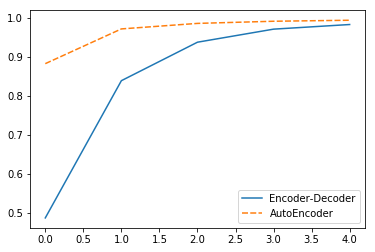

In [60]:
fig = sns.lineplot(data=l)

In [61]:
picture = fig.get_figure()
picture.savefig('EDvsAE2.png', dpi=100)